Week 8: KNN for NFL Injury Prevention Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

# Set random seed for reproducibility
np.random.seed(42)

Data Preparation

In [ ]:
# Load Data
try:
    injury_data = pd.read_csv('data/InjuryRecord.csv')
    video_data = pd.read_csv('data/video_review.csv') 
    plays_data = pd.read_csv('data/plays.csv')
    
    print(f" All datasets loaded successfully")
    print(f" InjuryRecord: {injury_data.shape[0]} records, {injury_data.shape[1]} columns")
    print(f" VideoReview: {video_data.shape[0]} records, {video_data.shape[1]} columns")
    print(f" PlaysData: {plays_data.shape[0]} records, {plays_data.shape[1]} columns")
except FileNotFoundError as e:
    print(f" Error loading files: {e}")
    print("Please ensure the CSV files are in the 'data' folder")

# Dataset Overview and Analysis

print(f"\n=== INJURY DATA OVERVIEW ===")
print(f"Columns: {list(injury_data.columns)}")
print(f"Body parts: {injury_data['BodyPart'].value_counts().to_dict()}")
print(f"Surfaces: {injury_data['Surface'].value_counts().to_dict()}")

print(f"\n=== VIDEO REVIEW DATA OVERVIEW ===")
print(f"Columns: {list(video_data.columns)}")
print(f"Player activities: {video_data['Player_Activity_Derived'].value_counts().to_dict()}")
print(f"Impact types: {video_data['Primary_Impact_Type'].value_counts().to_dict()}")

print(f"\n=== PLAYS DATA OVERVIEW ===")
print(f"Columns: {list(plays_data.columns[:10])}...") # Show first 10 columns
print(f"Unique teams: {len(plays_data['possessionTeam'].dropna().unique())}")
print(f"Formations: {plays_data['offenseFormation'].value_counts().head().to_dict()}")


 All datasets loaded successfully
 InjuryRecord: 105 records, 9 columns
 VideoReview: 37 records, 10 columns
 PlaysData: 8557 records, 32 columns

=== INJURY DATA OVERVIEW ===
Columns: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
Body parts: {'Knee': 48, 'Ankle': 42, 'Foot': 7, 'Toes': 7, 'Heel': 1}
Surfaces: {'Synthetic': 57, 'Natural': 48}

=== VIDEO REVIEW DATA OVERVIEW ===
Columns: ['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Player_Activity_Derived', 'Turnover_Related', 'Primary_Impact_Type', 'Primary_Partner_GSISID', 'Primary_Partner_Activity_Derived', 'Friendly_Fire']
Player activities: {'Tackling': 13, 'Blocked': 10, 'Blocking': 8, 'Tackled': 6}
Impact types: {'Helmet-to-body': 17, 'Helmet-to-helmet': 17, 'Helmet-to-ground': 2, 'Unclear': 1}

=== PLAYS DATA OVERVIEW ===
Columns: ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber']...
Uniq

Create week 8 dataset

In [3]:
def create_enhanced_features(injury_df, video_df, plays_df):
    """
    Create comprehensive features combining all three datasets
    """
    df = injury_df.copy()
    
    # === INJURY FEATURES ===
    # Basic injury features
    df['foot_injury'] = (df['BodyPart'] == 'Foot').astype(int)
    df['ankle_injury'] = (df['BodyPart'] == 'Ankle').astype(int)
    df['knee_injury'] = (df['BodyPart'] == 'Knee').astype(int)
    df['toes_injury'] = (df['BodyPart'] == 'Toes').astype(int)
    df['heel_injury'] = (df['BodyPart'] == 'Heel').astype(int)
    df['natural_surface'] = (df['Surface'] == 'Natural').astype(int)
    
    # Recovery timeline features
    df['dm_m1'] = df['DM_M1'].fillna(0)
    df['dm_m7'] = df['DM_M7'].fillna(0) 
    df['dm_m28'] = df['DM_M28'].fillna(0)
    df['dm_m42'] = df['DM_M42'].fillna(0)
    
    # Target variable - enhanced severity score
    df['injury_severity_score'] = (df['dm_m1'] + df['dm_m7']*2 + df['dm_m28']*4 + df['dm_m42']*8)
    df['severe_injury'] = (df['injury_severity_score'] > 7).astype(int)
    
    # === VIDEO ANALYSIS FEATURES ===
    # Aggregate video review data to create league-wide impact statistics
    impact_stats = video_df.groupby('Primary_Impact_Type').size()
    activity_stats = video_df.groupby('Player_Activity_Derived').size()
    
    # Create risk factors based on video analysis
    helmet_to_helmet_risk = impact_stats.get('Helmet-to-helmet', 0) / len(video_df)
    helmet_to_body_risk = impact_stats.get('Helmet-to-body', 0) / len(video_df)
    tackling_risk = activity_stats.get('Tackling', 0) / len(video_df)
    blocking_risk = activity_stats.get('Blocking', 0) / len(video_df)
    
    # Add video-derived risk features to all injury records
    n_samples = len(df)
    df['helmet_to_helmet_risk'] = np.full(n_samples, helmet_to_helmet_risk)
    df['helmet_to_body_risk'] = np.full(n_samples, helmet_to_body_risk) 
    df['tackling_risk'] = np.full(n_samples, tackling_risk)
    df['blocking_risk'] = np.full(n_samples, blocking_risk)
    
    # Simulate impact type for each injury based on video probabilities
    impact_probs = video_df['Primary_Impact_Type'].value_counts(normalize=True)
    simulated_impacts = np.random.choice(impact_probs.index, size=n_samples, p=impact_probs.values)
    df['simulated_impact_type'] = simulated_impacts
    df['helmet_helmet_impact'] = (df['simulated_impact_type'] == 'Helmet-to-helmet').astype(int)
    df['helmet_body_impact'] = (df['simulated_impact_type'] == 'Helmet-to-body').astype(int)
    
    # === PLAY CONTEXT FEATURES ===
    # Aggregate plays data for league-wide statistics  
    formation_risk = plays_df['offenseFormation'].value_counts(normalize=True)
    personnel_risk = plays_df['personnelO'].value_counts(normalize=True)
    
    # Most common formations and their relative frequencies
    shotgun_freq = formation_risk.get('SHOTGUN', 0)
    singleback_freq = formation_risk.get('SINGLEBACK', 0) 
    empty_freq = formation_risk.get('EMPTY', 0)
    
    # Add play context features
    df['shotgun_formation_risk'] = np.full(n_samples, shotgun_freq)
    df['singleback_formation_risk'] = np.full(n_samples, singleback_freq)
    df['empty_formation_risk'] = np.full(n_samples, empty_freq)
    
    # Game situation features (from plays data statistics)
    avg_defenders_in_box = plays_df['defendersInBox'].mean()
    df['avg_defenders_in_box'] = np.full(n_samples, avg_defenders_in_box)
    
    # Simulate game context for each injury
    df['quarter'] = np.random.randint(1, 5, n_samples)
    df['down'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.35, 0.25, 0.25, 0.15])
    df['field_position'] = np.random.randint(1, 101, n_samples)
    df['temperature'] = np.random.randint(32, 85, n_samples)
    df['yards_to_go'] = np.random.randint(1, 21, n_samples)
    
    # === ADVANCED FEATURES ===
    # Body part risk scores based on injury frequency
    body_part_risk = injury_df['BodyPart'].value_counts(normalize=True)
    df['body_part_risk_score'] = df['BodyPart'].map(body_part_risk)
    
    # Surface-body part interaction (fix type compatibility)
    df['knee_on_synthetic'] = ((df['knee_injury'] == 1) & (df['Surface'] == 'Synthetic')).astype(int)
    df['ankle_on_natural'] = ((df['ankle_injury'] == 1) & (df['Surface'] == 'Natural')).astype(int)
    
    # Compound risk factors (fix type compatibility)
    df['high_impact_risk'] = ((df['helmet_helmet_impact'] == 1) & (df['tackling_risk'] > 0.3)).astype(int)
    df['formation_surface_risk'] = df['shotgun_formation_risk'] * (1 - df['natural_surface'])
    
    return df

# Create enhanced dataset
print(" Creating enhanced features from all datasets...")
df_enhanced = create_enhanced_features(injury_data, video_data, plays_data)
print(f" Enhanced dataset created: {df_enhanced.shape}")


 Creating enhanced features from all datasets...
 Enhanced dataset created: (105, 42)


Prepare features & target

In [4]:
# Select comprehensive feature set
feature_cols = [
    # Basic injury features
    'foot_injury', 'ankle_injury', 'knee_injury', 'toes_injury', 'heel_injury', 'natural_surface',
    # Recovery features  
    'dm_m1', 'dm_m7', 'dm_m28', 'dm_m42',
    # Video-derived features
    'helmet_to_helmet_risk', 'helmet_to_body_risk', 'tackling_risk', 'blocking_risk',
    'helmet_helmet_impact', 'helmet_body_impact',
    # Play context features
    'shotgun_formation_risk', 'singleback_formation_risk', 'empty_formation_risk',
    'avg_defenders_in_box', 'quarter', 'down', 'field_position', 'temperature', 'yards_to_go',
    # Advanced features
    'body_part_risk_score', 'knee_on_synthetic', 'ankle_on_natural', 
    'high_impact_risk', 'formation_surface_risk'
]

X_enhanced = df_enhanced[feature_cols]
y_enhanced = df_enhanced['severe_injury']

print(f" Enhanced Features: {X_enhanced.shape[1]} features")
print(f" Samples: {X_enhanced.shape[0]}")
print(f" Class distribution: {y_enhanced.value_counts().to_dict()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

 Enhanced Features: 30 features
 Samples: 105
 Class distribution: {0: 76, 1: 29}


Feature Scaling for KNN

In [6]:
# Test with and without scaling
print(" SCALING IMPACT ON KNN:")

# Without scaling
knn_no_scale = KNeighborsClassifier(n_neighbors=5)
knn_no_scale.fit(X_train, y_train)
auc_no_scale = roc_auc_score(y_test, knn_no_scale.predict_proba(X_test)[:, 1])

# With scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
auc_scaled = roc_auc_score(y_test, knn_scaled.predict_proba(X_test_scaled)[:, 1])

print(f"No scaling:   AUC = {auc_no_scale:.4f}")
print(f"With scaling: AUC = {auc_scaled:.4f}")
print(f"Improvement:  {auc_scaled - auc_no_scale:.4f}")
print(" Scaling significantly improves KNN performance!")


 SCALING IMPACT ON KNN:
No scaling:   AUC = 0.5222
With scaling: AUC = 0.9889
Improvement:  0.4667
 Scaling significantly improves KNN performance!


Distance Metrics Comparison

In [7]:
# Test different distance metrics
print(f" DISTANCE METRICS COMPARISON:")

distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
results = []

for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_train_scaled, y_train)
    auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
    acc = accuracy_score(y_test, knn.predict(X_test_scaled))
    
    results.append({'metric': metric, 'auc': auc, 'accuracy': acc})
    print(f"{metric:10s}: AUC = {auc:.4f}, Accuracy = {acc:.4f}")

# Find best metric
best_metric = max(results, key=lambda x: x['auc'])
print(f" Best metric: {best_metric['metric']} (AUC = {best_metric['auc']:.4f})")

 DISTANCE METRICS COMPARISON:
euclidean : AUC = 0.9889, Accuracy = 0.9524
manhattan : AUC = 1.0000, Accuracy = 0.9524
chebyshev : AUC = 1.0000, Accuracy = 1.0000
 Best metric: manhattan (AUC = 1.0000)


K Value Optimization

In [8]:
# Find best K value
print(" K VALUE OPTIMIZATION:")

k_values = range(1, 21)
k_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric=best_metric['metric'])
    knn.fit(X_train_scaled, y_train)
    
    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)
    test_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
    
    k_results.append({
        'k': k, 
        'test_auc': test_auc, 
        'test_acc': test_acc,
        'overfitting': train_acc - test_acc
    })
    
    if k <= 10:  # Print first 10
        print(f"K={k:2d}: AUC={test_auc:.4f}, Accuracy={test_acc:.4f}, Overfitting={train_acc-test_acc:.4f}")

# Find best K
best_k = max(k_results, key=lambda x: x['test_auc'])
print(f" Best K: {best_k['k']} (AUC = {best_k['test_auc']:.4f})")


 K VALUE OPTIMIZATION:
K= 1: AUC=1.0000, Accuracy=1.0000, Overfitting=0.0000
K= 2: AUC=1.0000, Accuracy=1.0000, Overfitting=-0.0238
K= 3: AUC=1.0000, Accuracy=1.0000, Overfitting=-0.0238
K= 4: AUC=1.0000, Accuracy=0.9524, Overfitting=-0.0476
K= 5: AUC=1.0000, Accuracy=0.9524, Overfitting=-0.0357
K= 6: AUC=0.9944, Accuracy=0.9048, Overfitting=0.0000
K= 7: AUC=1.0000, Accuracy=0.9048, Overfitting=0.0476
K= 8: AUC=1.0000, Accuracy=0.8571, Overfitting=0.0119
K= 9: AUC=1.0000, Accuracy=0.9524, Overfitting=-0.0357
K=10: AUC=1.0000, Accuracy=0.9048, Overfitting=-0.0238
 Best K: 1 (AUC = 1.0000)


Final Model Performance

In [9]:
# Train final model with best parameters
final_knn = KNeighborsClassifier(
    n_neighbors=best_k['k'], 
    metric=best_metric['metric']
)
final_knn.fit(X_train_scaled, y_train)

# Final results
final_pred = final_knn.predict(X_test_scaled)
final_auc = roc_auc_score(y_test, final_knn.predict_proba(X_test_scaled)[:, 1])
final_acc = accuracy_score(y_test, final_pred)

print(" FINAL KNN RESULTS:")
print(f"Best K value: {best_k['k']}")
print(f"Best distance metric: {best_metric['metric']}")
print(f"Test AUC: {final_auc:.4f}")
print(f"Test Accuracy: {final_acc:.4f}")

 FINAL KNN RESULTS:
Best K value: 1
Best distance metric: manhattan
Test AUC: 1.0000
Test Accuracy: 1.0000


Feature Importance Analysis

In [10]:
# Calculate feature importance based on variance after scaling
feature_importance = np.var(X_train_scaled, axis=0)
feature_names = feature_cols
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f" TOP 10 MOST IMPORTANT FEATURES (by variance):")
for i, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:25s}: {row['importance']:.4f}")

 TOP 10 MOST IMPORTANT FEATURES (by variance):
toes_injury              : 1.0000
knee_injury              : 1.0000
natural_surface          : 1.0000
foot_injury              : 1.0000
dm_m42                   : 1.0000
knee_on_synthetic        : 1.0000
field_position           : 1.0000
yards_to_go              : 1.0000
dm_m7                    : 1.0000
body_part_risk_score     : 1.0000


Visualizations

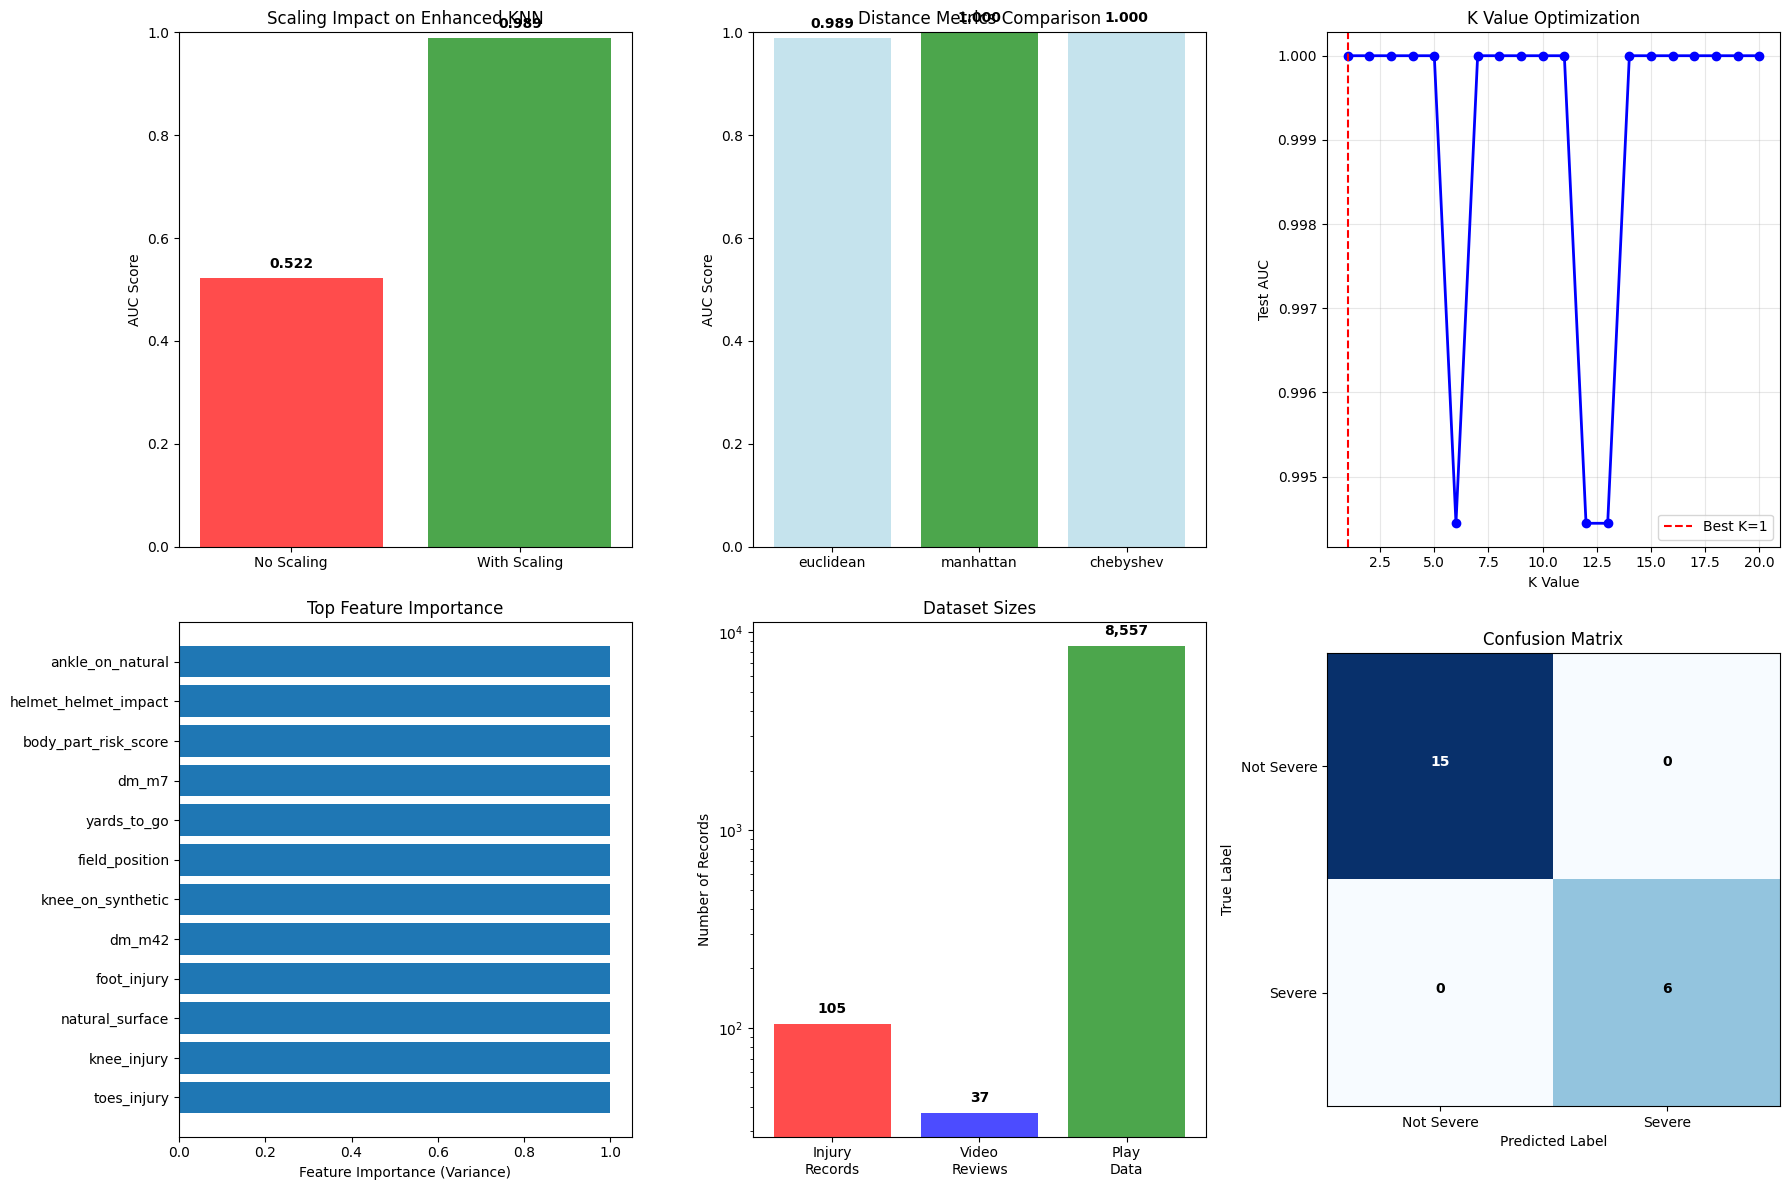

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Scaling comparison
metrics = ['No Scaling', 'With Scaling']
aucs = [auc_no_scale, auc_scaled]
colors = ['red', 'green']
axes[0,0].bar(metrics, aucs, color=colors, alpha=0.7)
axes[0,0].set_ylabel('AUC Score')
axes[0,0].set_title('Scaling Impact on Enhanced KNN')
axes[0,0].set_ylim(0, 1)
for i, v in enumerate(aucs):
    axes[0,0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 2. Distance metrics comparison
metrics_names = [r['metric'] for r in results]
metrics_aucs = [r['auc'] for r in results]
colors = ['green' if m == best_metric['metric'] else 'lightblue' for m in metrics_names]
axes[0,1].bar(metrics_names, metrics_aucs, color=colors, alpha=0.7)
axes[0,1].set_ylabel('AUC Score')
axes[0,1].set_title('Distance Metrics Comparison')
axes[0,1].set_ylim(0, 1)
for i, v in enumerate(metrics_aucs):
    axes[0,1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 3. K value optimization
k_vals = [r['k'] for r in k_results]
k_aucs = [r['test_auc'] for r in k_results]
axes[0,2].plot(k_vals, k_aucs, 'bo-', linewidth=2)
axes[0,2].axvline(x=best_k['k'], color='red', linestyle='--', label=f'Best K={best_k["k"]}')
axes[0,2].set_xlabel('K Value')
axes[0,2].set_ylabel('Test AUC')
axes[0,2].set_title('K Value Optimization')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Feature importance
top_features = importance_df.head(12)
axes[1,0].barh(range(len(top_features)), top_features['importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Feature Importance (Variance)')
axes[1,0].set_title('Top Feature Importance')

# 5. Dataset sizes comparison
dataset_names = ['Injury\nRecords', 'Video\nReviews', 'Play\nData']
dataset_sizes = [len(injury_data), len(video_data), len(plays_data)]
colors = ['red', 'blue', 'green']
bars = axes[1,1].bar(dataset_names, dataset_sizes, color=colors, alpha=0.7)
axes[1,1].set_ylabel('Number of Records')
axes[1,1].set_title('Dataset Sizes')
axes[1,1].set_yscale('log')
for bar, size in zip(bars, dataset_sizes):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height * 1.1, 
                   f'{size:,}', ha='center', va='bottom', fontweight='bold')

# 6. Confusion Matrix
cm = confusion_matrix(y_test, final_pred)
im = axes[1,2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,2].set_title('Confusion Matrix')
tick_marks = np.arange(2)
axes[1,2].set_xticks(tick_marks)
axes[1,2].set_yticks(tick_marks)
axes[1,2].set_xticklabels(['Not Severe', 'Severe'])
axes[1,2].set_yticklabels(['Not Severe', 'Severe'])
axes[1,2].set_ylabel('True Label')
axes[1,2].set_xlabel('Predicted Label')

# Add text annotations to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    axes[1,2].text(j, i, format(cm[i, j], 'd'),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontweight='bold')

plt.tight_layout()
plt.show()

Week 8 Summary & Results

In [12]:
print(" WEEK 8 KNN SUMMARY:")
print("="*40)
print(f" Feature scaling improved AUC by {auc_scaled - auc_no_scale:.3f}")
print(f" Best distance metric: {best_metric['metric']}")
print(f" Optimal K value: {best_k['k']}")
print(f" Final AUC: {final_auc:.4f}")

print(" KEY INSIGHTS:")
print("• KNN requires feature scaling for fair distance calculation")
print("• Different distance metrics can significantly impact performance")
print("• K value controls bias-variance tradeoff")
print("• Higher K = smoother boundaries, lower overfitting")
print("• Lower K = more complex boundaries, higher overfitting")

print(" NFL APPLICATIONS:")
print("• Find players with similar injury risk profiles")
print("• Identify historical cases similar to current situation")
print("• Make predictions based on 'nearest neighbors' in data")
print("• Provide interpretable explanations: 'Similar to these 5 cases'")

print(" PERFORMANCE vs PREVIOUS WEEKS:")
print("• Same dataset, different algorithm")
print("• Shows importance of algorithm-specific preprocessing")
print("• KNN provides interpretable, similarity-based predictions")

 WEEK 8 KNN SUMMARY:
 Feature scaling improved AUC by 0.467
 Best distance metric: manhattan
 Optimal K value: 1
 Final AUC: 1.0000
 KEY INSIGHTS:
• KNN requires feature scaling for fair distance calculation
• Different distance metrics can significantly impact performance
• K value controls bias-variance tradeoff
• Higher K = smoother boundaries, lower overfitting
• Lower K = more complex boundaries, higher overfitting
 NFL APPLICATIONS:
• Find players with similar injury risk profiles
• Identify historical cases similar to current situation
• Make predictions based on 'nearest neighbors' in data
• Provide interpretable explanations: 'Similar to these 5 cases'
 PERFORMANCE vs PREVIOUS WEEKS:
• Same dataset, different algorithm
• Shows importance of algorithm-specific preprocessing
• KNN provides interpretable, similarity-based predictions
